In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import os
import random
import xgboost
import lightgbm as lgb
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from multiprocessing import Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV 
#from sklearn.model_selection import cross_val_score,KFold
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
# Any results you write to the current directory are saved as output.

In [2]:
''' from here  https://www.kaggle.com/c/imet-2019-fgvc6/discussion/87675#latest-516375'''
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything()

In [3]:
train = pd.read_csv('../input/pmp-data-train/train_.csv')
train.drop('molecule_name', axis=1,inplace=True)
train.drop('atom_index_0' , axis=1,inplace=True)
train.drop('atom_index_1' , axis=1,inplace=True)
train.drop('id'           , axis=1,inplace=True)
train.drop(columns="Unnamed: 0",inplace=True)

In [4]:
train.head()

,type,scalar_coupling_constant,type0,charge0,type1,charge1,distance,type_0,charge_0,dist0_0,dist1_0,angle0_0,angle1_0,type_1,charge_1,dist0_1,dist1_1,angle0_1,angle1_1,type_2,charge_2,dist0_2,dist1_2,angle0_2,angle1_2,type_3,charge_3,dist0_3,dist1_3,angle0_3,angle1_3,type_4,charge_4,dist0_4,dist1_4,angle0_4,angle1_4,type_5,charge_5,dist0_5,dist1_5,angle0_5,angle1_5,type_6,charge_6,dist0_6,dist1_6,angle0_6,angle1_6,type_7,charge_7,dist0_7,dist1_7,angle0_7,angle1_7
0,1JHC,84.8076,1.0,0.133921,2.0,-0.535689,1.091953,1.0,0.133923,1.783147,1.091946,35.264217,109.471320,1.0,0.133923,1.783157,1.091948,35.263863,109.472070,1.0,0.133922,1.783120,1.091952,35.265770,109.468410,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0
1,2JHH,-11.2570,1.0,0.133921,1.0,0.133922,1.783120,2.0,-0.535689,1.091953,1.091952,35.265770,35.265823,1.0,0.133923,1.783147,1.783158,60.000893,60.000324,1.0,0.133923,1.783157,1.783148,60.000378,60.000840,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0
2,2JHH,-11.2548,1.0,0.133921,1.0,0.133923,1.783147,2.0,-0.535689,1.091953,1.091946,35.264217,35.264465,1.0,0.133922,1.783120,1.783158,60.000893,59.998783,1.0,0.133923,1.783157,1.783148,59.999844,60.000336,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0
3,2JHH,-11.2543,1.0,0.133921,1.0,0.133923,1.783157,2.0,-0.535689,1.091953,1.091948,35.263863,35.264070,1.0,0.133922,1.783120,1.783148,60.000378,59.998783,1.0,0.133923,1.783147,1.783148,59.999844,59.999820,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0
4,1JHC,84.8074,1.0,0.133922,2.0,-0.535689,1.091952,1.0,0.133923,1.783158,1.091946,35.263730,109.472350,1.0,0.133923,1.783148,1.091948,35.264214,109.471420,1.0,0.133921,1.783120,1.091953,35.265823,109.468410,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0,0.0,0.0,50.0,50.0,45.0,45.0


In [5]:
def group_mean_log_mae(y_true, y_pred, floor=1e-9):
    maes = np.absolute(y_true-y_pred).mean()
    return np.log(np.maximum(maes,floor).mean())

In [6]:
def mean_log_mae( y_pred, dataset, floor=1e-9):
    y_true = dataset.get_label()
    maes = np.absolute(y_true-y_pred).mean()
    return 'mean_log_mae', np.log(np.maximum(maes,floor).mean()), False

In [7]:
scores = []
models = {}
type_list = ['2JHC', '3JHH', '3JHC', '3JHN']

Dataset for type 2JHC has shape (1140674, 53)
Training until validation scores don't improve for 5 rounds.
[200]	valid_0's mean_log_mae: -0.693696
[400]	valid_0's mean_log_mae: -0.832808
[600]	valid_0's mean_log_mae: -0.914706
[800]	valid_0's mean_log_mae: -0.974034
[1000]	valid_0's mean_log_mae: -1.01968
[1200]	valid_0's mean_log_mae: -1.05514
[1400]	valid_0's mean_log_mae: -1.08601
[1600]	valid_0's mean_log_mae: -1.11147
[1800]	valid_0's mean_log_mae: -1.13521
[2000]	valid_0's mean_log_mae: -1.15629
[2200]	valid_0's mean_log_mae: -1.1762
[2400]	valid_0's mean_log_mae: -1.19302
[2600]	valid_0's mean_log_mae: -1.20747
[2800]	valid_0's mean_log_mae: -1.22116
[3000]	valid_0's mean_log_mae: -1.23463
[3200]	valid_0's mean_log_mae: -1.24646
[3400]	valid_0's mean_log_mae: -1.25685
[3600]	valid_0's mean_log_mae: -1.26659
[3800]	valid_0's mean_log_mae: -1.2759
[4000]	valid_0's mean_log_mae: -1.28459
[4200]	valid_0's mean_log_mae: -1.29244
[4400]	valid_0's mean_log_mae: -1.2999
[4600]	valid_0's

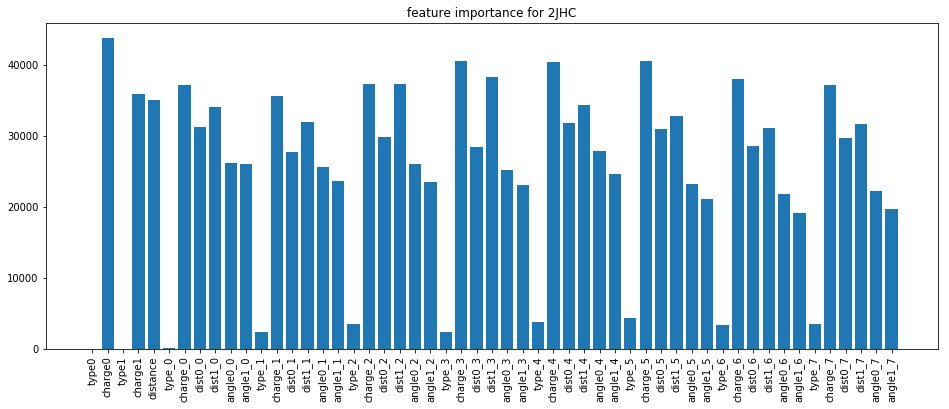

In [8]:
# Number of examples = 1140674
Type = '2JHC' 
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': "None",
    'num_leaves': 120,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}
num_round = 24000
data = train.loc[train['type'] == Type].copy()
data.reset_index(inplace=True)
data.drop('type', axis=1,inplace=True)
data.drop('index', axis=1,inplace=True)
y =  data.scalar_coupling_constant.values
data.drop('scalar_coupling_constant', axis=1,inplace=True)
X =  data.astype(float).values
features =  data.columns
print('Dataset for type {} has shape {}'.format(Type,X.shape))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
lgb_train = lgb.Dataset(X_train, y_train,free_raw_data=False)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train,free_raw_data=False)
reg = lgb.train (   
                    params,
                    train_set       = lgb_train,
                    num_boost_round = num_round,
                    valid_sets      = lgb_eval,
                    feval           = mean_log_mae,
                    verbose_eval    = 200,
                    early_stopping_rounds = 5
                )
print(y_test[0:5])
print(reg.predict(X_test[0:5], num_iteration=reg.best_iteration).tolist())
score = group_mean_log_mae(y_test,reg.predict(X_test, num_iteration=reg.best_iteration))
scores.append(score)
models[Type] = reg
reg.save_model(f'model_{Type}.txt', num_iteration=reg.best_iteration)
print('score for type {}  is -------->  {}'.format(Type,score))
plt.figure(figsize = (16,6))
plt.bar(range(len(reg.feature_importance())), reg.feature_importance())
plt.xticks(range(len(reg.feature_importance())), features, rotation='vertical')
plt.title(f'feature importance for {Type}')
plt.show()

Dataset for type 3JHH has shape (590611, 53)
Training until validation scores don't improve for 5 rounds.
[200]	valid_0's mean_log_mae: -1.24159
[400]	valid_0's mean_log_mae: -1.39824
[600]	valid_0's mean_log_mae: -1.49243
[800]	valid_0's mean_log_mae: -1.55753
[1000]	valid_0's mean_log_mae: -1.60542
[1200]	valid_0's mean_log_mae: -1.64452
[1400]	valid_0's mean_log_mae: -1.67962
[1600]	valid_0's mean_log_mae: -1.70824
[1800]	valid_0's mean_log_mae: -1.73054
[2000]	valid_0's mean_log_mae: -1.75124
[2200]	valid_0's mean_log_mae: -1.77024
[2400]	valid_0's mean_log_mae: -1.78668
[2600]	valid_0's mean_log_mae: -1.80099
[2800]	valid_0's mean_log_mae: -1.81297
[3000]	valid_0's mean_log_mae: -1.82497
[3200]	valid_0's mean_log_mae: -1.83615
[3400]	valid_0's mean_log_mae: -1.84631
[3600]	valid_0's mean_log_mae: -1.85519
[3800]	valid_0's mean_log_mae: -1.86316
[4000]	valid_0's mean_log_mae: -1.87046
[4200]	valid_0's mean_log_mae: -1.87814
[4400]	valid_0's mean_log_mae: -1.88538
[4600]	valid_0's m

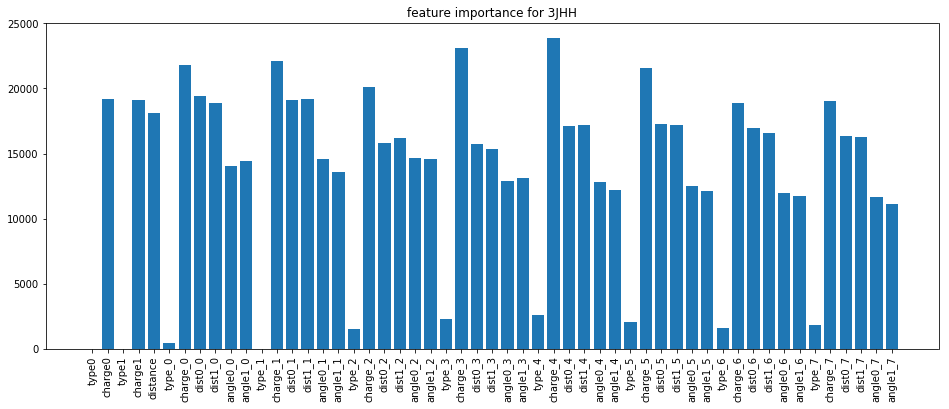

In [9]:
# Number of examples = 590611
Type = '3JHH' 
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': "None",
    'num_leaves': 120,
    'learning_rate': 0.08,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}
num_round = 24000
data = train.loc[train['type'] == Type].copy()
data.reset_index(inplace=True)
data.drop('type', axis=1,inplace=True)
data.drop('index', axis=1,inplace=True)
y =  data.scalar_coupling_constant.values
data.drop('scalar_coupling_constant', axis=1,inplace=True)
X =  data.astype(float).values
features =  data.columns
print('Dataset for type {} has shape {}'.format(Type,X.shape))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
lgb_train = lgb.Dataset(X_train, y_train,free_raw_data=False)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train,free_raw_data=False)
reg = lgb.train (   
                    params,
                    train_set       = lgb_train,
                    num_boost_round = num_round,
                    valid_sets      = lgb_eval,
                    feval           = mean_log_mae,
                    verbose_eval    = 200,
                    early_stopping_rounds = 5
                )
print(y_test[0:5])
print(reg.predict(X_test[0:5], num_iteration=reg.best_iteration).tolist())
score = group_mean_log_mae(y_test,reg.predict(X_test, num_iteration=reg.best_iteration))
scores.append(score)
models[Type] = reg
reg.save_model(f'model_{Type}.txt', num_iteration=reg.best_iteration)
print('score for type {}  is -------->  {}'.format(Type,score))
plt.figure(figsize = (16,6))
plt.bar(range(len(reg.feature_importance())), reg.feature_importance())
plt.xticks(range(len(reg.feature_importance())), features, rotation='vertical')
plt.title(f'feature importance for {Type}')
plt.show()

Dataset for type 3JHC has shape (1510379, 53)
Training until validation scores don't improve for 5 rounds.
[200]	valid_0's mean_log_mae: -0.592627
[400]	valid_0's mean_log_mae: -0.736859
[600]	valid_0's mean_log_mae: -0.817063
[800]	valid_0's mean_log_mae: -0.876452
[1000]	valid_0's mean_log_mae: -0.922403
[1200]	valid_0's mean_log_mae: -0.960545
[1400]	valid_0's mean_log_mae: -0.995281
[1600]	valid_0's mean_log_mae: -1.02373
[1800]	valid_0's mean_log_mae: -1.04782
[2000]	valid_0's mean_log_mae: -1.06915
[2200]	valid_0's mean_log_mae: -1.08809
[2400]	valid_0's mean_log_mae: -1.10644
[2600]	valid_0's mean_log_mae: -1.12214
[2800]	valid_0's mean_log_mae: -1.1365
[3000]	valid_0's mean_log_mae: -1.15001
[3200]	valid_0's mean_log_mae: -1.16279
[3400]	valid_0's mean_log_mae: -1.17442
[3600]	valid_0's mean_log_mae: -1.18482
[3800]	valid_0's mean_log_mae: -1.19501
[4000]	valid_0's mean_log_mae: -1.20432
[4200]	valid_0's mean_log_mae: -1.21305
[4400]	valid_0's mean_log_mae: -1.22131
[4600]	vali

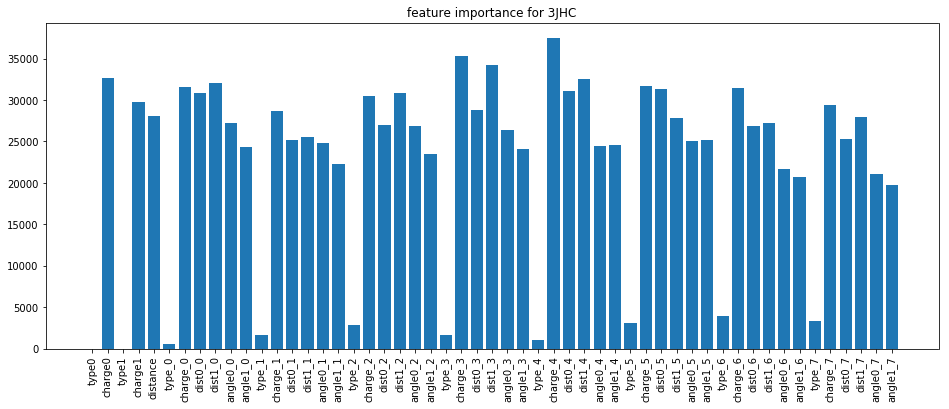

In [10]:
# Number of examples = 1510379
Type = '3JHC' 
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': "None",
    'num_leaves': 120,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}
num_round = 24000
data = train.loc[train['type'] == Type].copy()
data.reset_index(inplace=True)
data.drop('type', axis=1,inplace=True)
data.drop('index', axis=1,inplace=True)
y =  data.scalar_coupling_constant.values
data.drop('scalar_coupling_constant', axis=1,inplace=True)
X =  data.astype(float).values
features =  data.columns
print('Dataset for type {} has shape {}'.format(Type,X.shape))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
lgb_train = lgb.Dataset(X_train, y_train,free_raw_data=False)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train,free_raw_data=False)
reg = lgb.train (   
                    params,
                    train_set       = lgb_train,
                    num_boost_round = num_round,
                    valid_sets      = lgb_eval,
                    feval           = mean_log_mae,
                    verbose_eval    = 200,
                    early_stopping_rounds = 5
                )
print(y_test[0:5])
print(reg.predict(X_test[0:5], num_iteration=reg.best_iteration).tolist())
score = group_mean_log_mae(y_test,reg.predict(X_test, num_iteration=reg.best_iteration))
scores.append(score)
models[Type] = reg
reg.save_model(f'model_{Type}.txt', num_iteration=reg.best_iteration)
print('score for type {}  is -------->  {}'.format(Type,score))
plt.figure(figsize = (16,6))
plt.bar(range(len(reg.feature_importance())), reg.feature_importance())
plt.xticks(range(len(reg.feature_importance())), features, rotation='vertical')
plt.title(f'feature importance for {Type}')
plt.show()

Dataset for type 3JHN has shape (166415, 53)


/opt/conda/lib/python3.6/site-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[200]	valid_0's mean_log_mae: -1.57472
[400]	valid_0's mean_log_mae: -1.83854
[600]	valid_0's mean_log_mae: -1.91426
[800]	valid_0's mean_log_mae: -1.99593
[1000]	valid_0's mean_log_mae: -2.06008
[1200]	valid_0's mean_log_mae: -2.09745
[1400]	valid_0's mean_log_mae: -2.15376
[1600]	valid_0's mean_log_mae: -2.18272
[1800]	valid_0's mean_log_mae: -2.2147
[2000]	valid_0's mean_log_mae: -2.2428
[2200]	valid_0's mean_log_mae: -2.28006
[2400]	valid_0's mean_log_mae: -2.31159
[2600]	valid_0's mean_log_mae: -2.32594
[2800]	valid_0's mean_log_mae: -2.32927
[3000]	valid_0's mean_log_mae: -2.35525
[3200]	valid_0's mean_log_mae: -2.36673
[3400]	valid_0's mean_log_mae: -2.39225
[3600]	valid_0's mean_log_mae: -2.40459
[3800]	valid_0's mean_log_mae: -2.4176
[4000]	valid_0's mean_log_mae: -2.42776
[4200]	valid_0's mean_log_mae: -2.43251
[4400]	valid_0's mean_log_mae: -2.43572
[4600]	valid_0's mean_log_mae: -2.43872
[4800]	valid_0's mean_log_mae: -2.45314
[5000]	valid_0's mean_log_mae: -2.46307
[5200]	

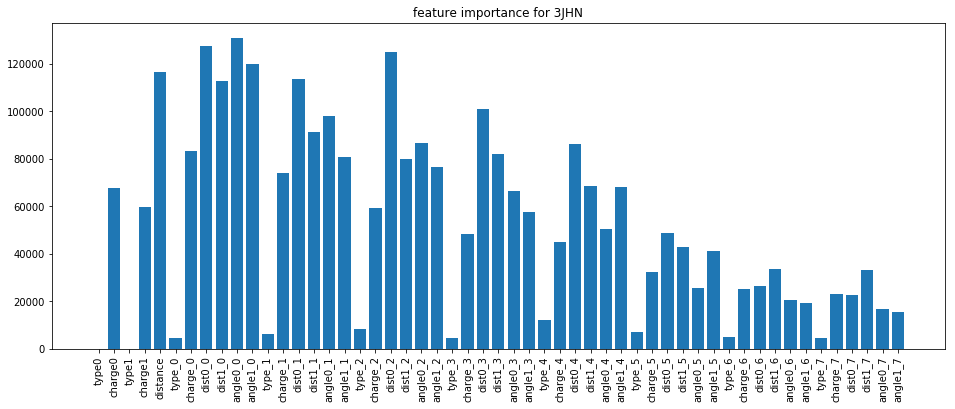

In [11]:
# Number of examples = 166415
Type = '3JHN' 
params = {
    'boosting_type': 'dart',
    'objective': 'regression',
    'metric': "None",
    'num_leaves': 120,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}
num_round = 24000
data = train.loc[train['type'] == Type].copy()
data.reset_index(inplace=True)
data.drop('type', axis=1,inplace=True)
data.drop('index', axis=1,inplace=True)
y =  data.scalar_coupling_constant.values
data.drop('scalar_coupling_constant', axis=1,inplace=True)
X =  data.astype(float).values
features =  data.columns
print('Dataset for type {} has shape {}'.format(Type,X.shape))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
lgb_train = lgb.Dataset(X_train, y_train,free_raw_data=False)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train,free_raw_data=False)
reg = lgb.train (   
                    params,
                    train_set       = lgb_train,
                    num_boost_round = num_round,
                    valid_sets      = lgb_eval,
                    feval           = mean_log_mae,
                    verbose_eval    = 200,
                    early_stopping_rounds = 5
                )
print(y_test[0:5])
print(reg.predict(X_test[0:5], num_iteration=reg.best_iteration).tolist())
score = group_mean_log_mae(y_test,reg.predict(X_test, num_iteration=reg.best_iteration))
scores.append(score)
models[Type] = reg
reg.save_model(f'model_{Type}.txt', num_iteration=reg.best_iteration)
print('score for type {}  is -------->  {}'.format(Type,score))
plt.figure(figsize = (16,6))
plt.bar(range(len(reg.feature_importance())), reg.feature_importance())
plt.xticks(range(len(reg.feature_importance())), features, rotation='vertical')
plt.title(f'feature importance for {Type}')
plt.show()

In [12]:
score = np.array(scores).mean()
print('Final score is {}'.format(score))
for i,type_ in enumerate(type_list): print('score of type {} is {}'.format(type_,scores[i]))

Final score is -1.839054188716259
score of type 2JHC is -1.4289135609371875
score of type 3JHH is -1.926762765385606
score of type 3JHC is -1.3504152515798082
score of type 3JHN is -2.6501251769624345


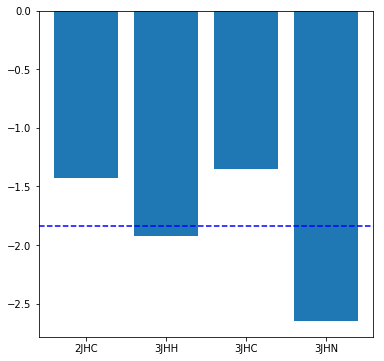

In [13]:
plt.figure(figsize = (6,6))
plt.bar(range(len(scores)), scores)
plt.xticks(range(len(scores)), type_list)
plt.axhline(y=score, color='b', linestyle='--')
plt.show()

In [14]:
# params = [0,0,0,0,0,0,0,0]
# params[0] = {
#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': "None",
#     'num_leaves': 100,
#     'learning_rate': 0.1,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'verbose': 0
# }
# params[1] = {
#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': "None",
#     'num_leaves': 80,
#     'learning_rate': 0.03,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'verbose': 0
# }
# params[2] = {
#     'boosting_type': 'dart',
#     'objective': 'regression',
#     'metric': "None",
#     'num_leaves': 80,
#     'learning_rate': 0.1,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'verbose': 0
# }
# params[3] = {
#     'boosting_type': 'dart',
#     'objective': 'regression',
#     'metric': "None",
#     'num_leaves': 80,
#     'learning_rate': 0.1,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'verbose': 0
# }
# params[4] = {
#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': "None",
#     'num_leaves': 80,
#     'learning_rate': 0.1,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'verbose': 0
# }
# params[5] = {
#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': "None",
#     'num_leaves': 80,
#     'learning_rate': 0.08,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'verbose': 0
# }
# params[6] = {
#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': "None",
#     'num_leaves': 80,
#     'learning_rate': 0.1,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'verbose': 0
# }
# params[7] = {
#     'boosting_type': 'dart',
#     'objective': 'regression',
#     'metric': "None",
#     'num_leaves': 80,
#     'learning_rate': 0.1,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'verbose': 0
# }
# num = [24000,24000,24000,24000,24000,24000,24000,24000]
# #num = [2, 2, 2, 2, 2, 2, 2, 2] #for debugging

In [15]:
# data_fr = {}
# #, '2JHC', '3JHH', '3JHC', '3JHN']
# models ={}
# scores = []
# for i,type_ in enumerate(type_list):
#     data_fr[type_] = train.loc[train['type'] == type_].copy()
#     data_fr[type_].reset_index(inplace=True)
#     data_fr[type_].drop('type', axis=1,inplace=True)
#     data_fr[type_].drop('index', axis=1,inplace=True)
#     y =  data_fr[type_].scalar_coupling_constant.values
#     data_fr[type_].drop('scalar_coupling_constant', axis=1,inplace=True)
#     X =  data_fr[type_].astype(float).values
#     features =  data_fr[type_].columns
#     print('Dataset for type {} has shape {}'.format(type_,X.shape))
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#     lgb_train = lgb.Dataset(X_train, y_train,free_raw_data=False)
#     lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train,free_raw_data=False)
#     reg = lgb.train (   
#                         params[i],
#                         train_set       = lgb_train,
#                         num_boost_round = num[i],
#                         valid_sets      = lgb_eval,
#                         feval           = mean_log_mae,
#                         verbose_eval    = 200,
#                         early_stopping_rounds = 5
#                     )
#     print(y_test[0:5])
#     print(reg.predict(X_test[0:5], num_iteration=reg.best_iteration).tolist())
#     score = group_mean_log_mae(y_test,reg.predict(X_test, num_iteration=reg.best_iteration))
#     scores.append(score)
#     models[type_] = reg
#     reg.save_model(f'model_{type_}.txt', num_iteration=reg.best_iteration)

#     print('score for type {}  is -------->  {}'.format(type_,score))

In [16]:
# plt.figure(figsize = (16,6))
# plt.bar(range(len(reg.feature_importance())), reg.feature_importance())
# plt.xticks(range(len(reg.feature_importance())), features, rotation='vertical')
# plt.show()

In [17]:
# test = pd.read_csv('../input/csv-s/test_.csv')
# test.drop('molecule_name', axis=1,inplace=True)
# test.drop('atom_index_0' , axis=1,inplace=True)
# test.drop('atom_index_1' , axis=1,inplace=True)
# test.drop('id'           , axis=1,inplace=True)
# test.drop(columns="Unnamed: 0",inplace=True)

In [18]:
# test.head()

In [19]:
# test_ = test.copy()
# test_.drop('type', axis=1,inplace=True)
# X =  test_.astype(float).values
# features = test_.columns
# print(X.shape)
# test_.head()

In [20]:
# %%time
# preds = {}
# for i,type_ in enumerate(type_list,1):
#     reg = models[type_]
#     predic = reg.predict(X, num_iteration=reg.best_iteration)
#     preds[type_]= predic
#     print(predic.shape)

In [21]:
# for i,type_ in enumerate(type_list,1): print('Mean prediction for type {} is {}'.format(type_,preds[type_].mean()))

In [22]:
# sam = pd.read_csv('../input/champs-scalar-coupling/sample_submission.csv')

In [23]:
# sam.head()

In [24]:
# %%time
# sam['scalar_coupling_constant'] = sam['scalar_coupling_constant'].astype(float)
# for i in range(sam.shape[0]):
#     type_ = test['type'][i]
#     value = models[type_].predict(np.expand_dims(X[i], axis=0), num_iteration=models[type_].best_iteration)
#     sam.at[i, 'scalar_coupling_constant'] = value

In [25]:
# sam['scalar_coupling_constant'] = sam['scalar_coupling_constant'].astype(float)
# for i in range(sam.shape[0]):
#     type_ = test['type'][i]
#     value = preds[type_][i]
#     sam.at[i, 'scalar_coupling_constant'] = value

In [26]:
# print(sam.head())
# sam.to_csv('submission.csv',index=None)

In [27]:
# parameters_for_testing = {
#    'gamma':[0,0.03,0.1,0.3],
#    'min_child_weight':[1.5,6,10],
#    'learning_rate':[0.07,0.1,0.5,1],
#    'max_depth':[3,4,5,6],
#    'n_estimators':[10],
#  }

# xgb_model = xgboost.XGBRegressor(learning_rate =0.1, n_estimators=10, max_depth=6,
#                                  min_child_weight=1, gamma=0, subsample=0.8,
#                                  colsample_bytree=0.8, nthread=6, 
#                                  scale_pos_weight=1, seed=42)

# gsearch = GridSearchCV(estimator = xgb_model, cv=3, param_grid=parameters_for_testing, 
#                        n_jobs=10,iid=False, verbose=10, scoring='neg_mean_squared_error')
# gsearch.fit(X_train,y_train)
# print('best params')
# print (gsearch.best_params_)
# print('best score')
# print (gsearch.best_score_)

In [28]:
# parameters_for_testing = {
#    'reg_alpha':[0,0.03,0.1,0.3],
#    'reg_labda':[1.5,6,10],
#    'n_estimators':[100],
#  }

# xgb_model = xgboost.XGBRegressor(learning_rate=0.5, 
#                                  n_estimators=100,
#                                  max_depth=6,
#                                  min_child_weight=1.5,
#                                  gamma=0,
#                                  nthread=6, 
#                                  scale_pos_weight=1,
#                                  seed=42)

# gsearch1 = GridSearchCV(estimator = xgb_model, cv=3, param_grid=parameters_for_testing,
#                         n_jobs=10,iid=False, verbose=10, scoring='neg_mean_squared_error')
# gsearch1.fit(X_train,y_train)
# print('best params')
# print (gsearch1.best_params_)
# print('best score')
# print (gsearch1.best_score_)

In [29]:
# reg = xgboost.XGBRegressor(
#                              learning_rate=0.5, 
#                              n_estimators=100,
#                              max_depth=6,
#                              min_child_weight=1.5,
#                              gamma=0,
#                              nthread=6, 
#                              scale_pos_weight=1,
#                              reg_alpha=0.3,
#                              reg_lambda=1.5,
#                              seed=42
#                           )
# reg.fit(X_train,y_train);
# print('score is {}'.format(group_mean_log_mae(pd.DataFrame(y_test),pd.DataFrame(reg.predict(X_test)))))

In [30]:
# plt.figure(figsize = (12,6))
# plt.bar(range(len(reg.feature_importances_)), reg.feature_importances_)
# plt.xticks(range(len(reg.feature_importances_)), fea, rotation='vertical')
# plt.show()

In [31]:
# from sklearn import linear_model
# reg = linear_model.RidgeCV()
# reg.fit(X_train, y_train)
# group_mean_log_mae(pd.DataFrame(y_test),pd.DataFrame(reg.predict(X_test)))
# print(y_train[0:5])
# print(reg.predict(X_train[0:5]).tolist())

In [32]:
# from sklearn.svm import SVR
# reg = SVR(gamma='scale', kernel='rbf', max_iter=2000)
# reg.fit(X_train, y_train)
# group_mean_log_mae(pd.DataFrame(y_test),pd.DataFrame(reg.predict(X_test)))

In [33]:
# import torch
# X_trainc = torch.tensor(X_train,dtype=torch.float).cuda()
# Y_trainc = torch.tensor(y_train,dtype=torch.float).cuda() 
# X_testc  = torch.tensor(X_test,dtype=torch.float).cuda()
# Y_testc  = torch.tensor(y_test,dtype=torch.float).cuda()
# class Net(torch.nn.Module):
#     def __init__(self, D_in, D_out):
#         super(Net, self).__init__()
#         self.linear1 = torch.nn.Linear(D_in, 100)
#         self.linear2 = torch.nn.Linear(100, 20)
#         self.linear3 = torch.nn.Linear(20, D_out)
#         self.drop1 = torch.nn.Dropout(p=0.45, inplace=False)
#         self.drop2 = torch.nn.Dropout(p=0.45, inplace=False)
#         self.relu = torch.nn.ReLU()
#     def forward(self, x):
#         x = self.relu(self.linear1(x))
#         x = self.drop1(x)
#         x = self.relu(self.linear2(x))
#         x = self.drop2(x)
#         y_pred = self.linear3(x)
#         return y_pred
# model = Net(44,1).cuda()
# criterion = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# step = torch.optim.lr_scheduler.StepLR(optimizer,100, gamma = 0.5, last_epoch=-1)
# def acc(model):
#     y_p = model(X_testc).detach().cpu().numpy()
#     print(group_mean_log_mae(pd.DataFrame(y_test),pd.DataFrame(y_p)))
# acc(model)
# model.train()
# for i in range(1501):
#     if i < 310: step.step()
#     model.train()
#     optimizer.zero_grad()
#     y_pred = model(X_testc)
#     loss = criterion(y_pred, Y_testc)
#     loss.backward()
#     optimizer.step()
#     if i%30 == 0: acc(model)

In [34]:
# lgb_train = lgb.Dataset(X_train, y_train)
# lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# def mean_log_mae( y_pred, dataset, floor=1e-9):
#     y_true = dataset.get_label()
#     maes = (pd.DataFrame(y_true)-pd.DataFrame(y_pred)).abs().mean()
#     return 'mean_log_mae', np.log(maes.map(lambda x: max(x, floor))).mean(), False

# def mean_log_mae( y_pred, dataset, floor=1e-9):
#     y_true = dataset.get_label()
#     maes = np.absolute(y_true-y_pred).mean()
#     return np.log(np.maximum(maes,floor).mean())

# params = {
#     'num_leaves'      : [40],
#     'learning_rate'   : [0.2, 0.3, 0.4],
#     'num_boost_round' : [4000]
#  }

# print('Starting training...')
# # train
# reg = lgb.LGBMRegressor(boosting_type ='gbdt',
#                         objective     = 'regression',
#                         verbose_eval  = 200)


# gbm = GridSearchCV(estimator = reg, cv=3, param_grid=params, 
#                    n_jobs=6, iid=False, verbose=10, scoring='neg_mean_squared_error')

# gbm.fit(X_train, y_train)
# print('best params')
# print (gbm.best_params_)
# print('best score')
# print (gbm.best_score_)